# **Eastspring Syariah Fixed Income Amanah Kelas A**

- Scaler: StandardScaler

## **Importing Libraries**

In [ ]:
#main
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

#viz
import seaborn as sns 

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20,8)

# Feature Selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Preprocessing Libraries
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Import Classification Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Import Evaluation Libraries for Classification
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

#mod
import tensorflow as tf
from tensorflow.keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM, Dropout 
from sklearn.metrics import mean_absolute_error

# Save and Load Model
import joblib
import json

## **Data Loading**

In [ ]:
# Data Loading Raw
url = 'https://raw.githubusercontent.com/H8-Assignments-Bay/p2---final-project-ftds-016-rmt-group-002/main/Dataset_clean/Med%20Clean/Eastspring%20Syariah%20Fixed%20Income%20Amanah%20Kelas%20A%20Clean.csv'
df = pd.read_csv(url)
df.head()

,Unnamed: 0,Date,Present,Next,Class
0,0,2022-09-16,1357.52,1358.01,1
1,1,2022-09-19,1358.01,1358.05,1
2,2,2022-09-20,1358.05,1357.91,0
3,3,2022-09-21,1357.91,1356.61,0
4,4,2022-09-22,1356.61,1354.72,0


In [ ]:
df.tail()

,Unnamed: 0,Date,Present,Next,Class
61,61,2022-12-12,1364.91,1364.81,0
62,62,2022-12-13,1364.81,1365.89,1
63,63,2022-12-14,1365.89,1364.22,0
64,64,2022-12-15,1364.22,1365.38,1
65,65,2022-12-16,1365.38,NaN,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  66 non-null     int64  
 1   Date        66 non-null     object 
 2   Present     66 non-null     float64
 3   Next        65 non-null     float64
 4   Class       66 non-null     int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 2.7+ KB


In [ ]:
# Checking if the dataframe is already in the type we want to use
df['Date'] = pd.to_datetime(df['Date'])
# df.rename(columns = {'date':'Date', 'value':'Present', 'next_value':'Next','class':'Class'}, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  66 non-null     int64         
 1   Date        66 non-null     datetime64[ns]
 2   Present     66 non-null     float64       
 3   Next        65 non-null     float64       
 4   Class       66 non-null     int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 2.7 KB


## **EDA**

### **Labels Analysis**

Labels between up and down are **imbalanced**.

In [ ]:
# Label counts
df.Class.value_counts()

1    37
0    29
Name: Class, dtype: int64

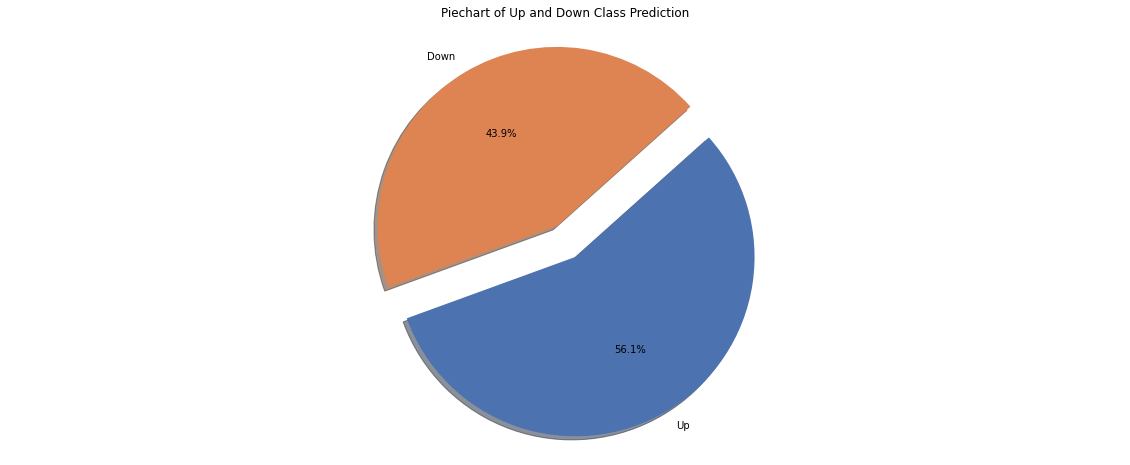

In [ ]:
# Creating Plot piechart of Up and Down labels
ClassType = dict(df.Class.value_counts())
labels = 'Up', 'Down'
sizes = [ClassType[1], ClassType[0]]
explode = (0, 0.2)

with sns.color_palette("deep"):
    plt.pie(sizes, explode=explode, labels=labels,
    autopct='%1.1f%%', shadow=True, startangle=200)

# Plot title
plt.axis('equal')
plt.title('Piechart of Up and Down Class Prediction')
plt.show()
     

### **NAV Analysis**

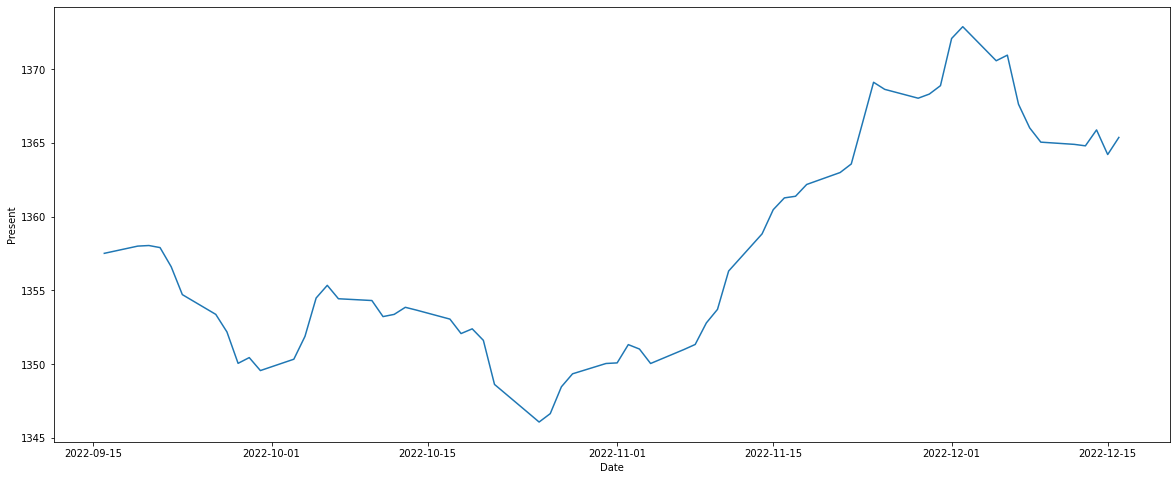

In [ ]:
# Lineplot Present NAV
present_nav = sns.lineplot(data=df, x="Date", y="Present")
present_nav

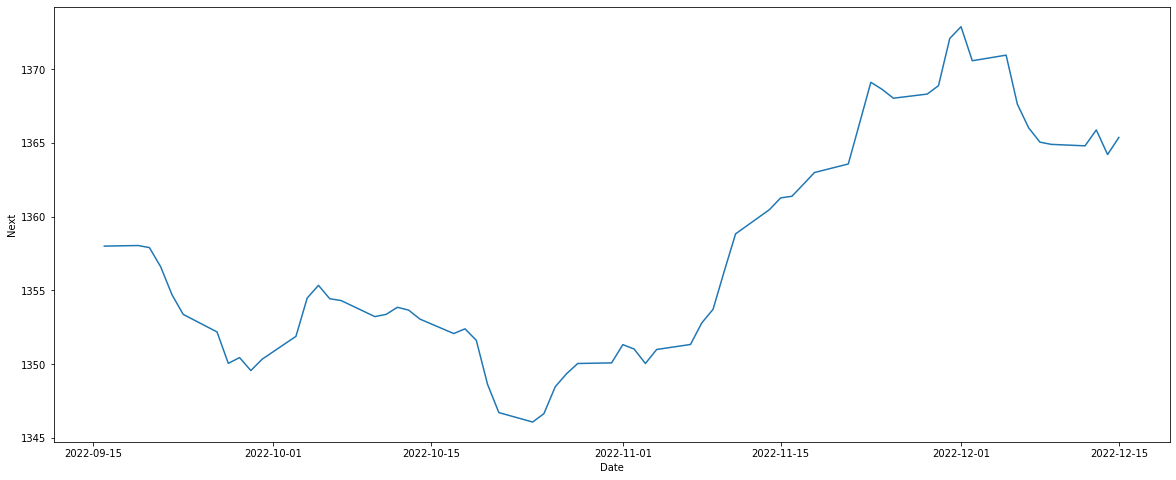

In [ ]:
# Lineplot Present NAV
next_nav = sns.lineplot(data=df, x="Date", y="Next")
next_nav

### **Correlation Analysis**

Apparently "Next" NAV" is 100% correlated with "Present" NAV. People tend to predict NAV at least a day before. However, the class correlation with NAV has weak correlations. This means, the model prediction depends on NAV, both Present and Next.

The prediction will be using Regression and Classification.

In [ ]:
# Creating new dataframe for NAV and Class correlation
nav_correlation = ['Present', 'Next', 'Class']
df_corr = df[nav_correlation]
df_corr.head()

,Present,Next,Class
0,1357.52,1358.01,1
1,1358.01,1358.05,1
2,1358.05,1357.91,0
3,1357.91,1356.61,0
4,1356.61,1354.72,0


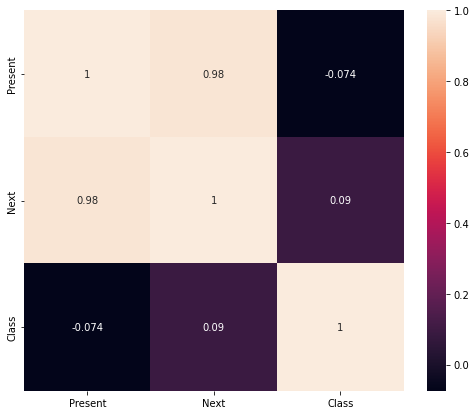

In [ ]:
# Plotting Correlation Matrix of NAV and Class
plt.figure(figsize=(8.5,7))
sns.heatmap(df_corr.corr(),annot=True)

## **Data Preprocessing**

### **Data Inference**

In [ ]:
# Dropping unneccessary features
df_ori = df.copy()

df = df.drop([65])
df = df.drop(['Unnamed: 0'],axis=1)

In [ ]:
# Creating data inference
df_inf = df.sample(5, random_state=33).sort_index()
df_inf

,Date,Present,Next,Class
5,2022-09-23,1354.72,1353.38,0
6,2022-09-26,1353.38,1352.19,0
29,2022-10-27,1348.47,1349.35,1
48,2022-11-23,1366.34,1369.12,1
61,2022-12-12,1364.91,1364.81,0


In [ ]:
# Drop data inference as a new dataframe
df_train_test = df.drop(df_inf.index)
df_train_test.shape

(60, 4)

### **Train-Test Set**

There is no need to drop any feature. However, train-test dataset splitting needs to be done.

In [ ]:
# Defining X and y
X = df_train_test.drop(['Class','Date'],axis=1)
y = pd.DataFrame(df_train_test['Class'])

#### **Imbalanced Data**

Imbalanced Data should be handled first to reduce the bias of the model results, especially for the label/target. The Imbalanced Data will be done by Oversampling.

In [ ]:
print('Original number of target: ', len(y))

Original number of target:  60


In [ ]:
# Define Oversampling
from imblearn.over_sampling import SMOTE

# Define Oversampling
smote = SMOTE(random_state=42)

# Fit an resample
X, y = smote.fit_resample(X, y)

In [ ]:
print('New number of target after oversampling: ', len(y))

New number of target after oversampling:  70


In [ ]:
# Number of Class after oversampling
y.Class.value_counts()

1    35
0    35
Name: Class, dtype: int64

#### **Train-Test Set Splitting**

In [ ]:
# Splitting dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=3)

print('Train size : ', X_train.shape)
print('Test size. : ', X_test.shape)

X_train.head()

Train size :  (49, 2)
Test size. :  (21, 2)


,Present,Next
28,1350.050000,1350.090000
18,1353.670000,1353.060000
9,1350.340000,1351.890000
25,1346.080000,1346.650000
66,1350.485205,1349.541715


### **Pipelines**

#### **Data Skewness**

Numerical scaler that will be used is MinMaxScaler because of data skewnesses are more than 0.5, which is not even Normal at all.

In [ ]:
X_train.skew()

Present    0.356712
Next       0.334718
dtype: float64

#### **Making Pipelines**

In [ ]:
num_columns = ['Present', 'Next']
print('Numerical columns  : ', num_columns)

Numerical columns  :  ['Present', 'Next']


In [ ]:
# Preprocessing for numerical data
numerical_pipe = Pipeline(steps=
                          [('scaler', StandardScaler())])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipe, num_columns)
    ])
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['Present', 'Next'])])

## **Model Definition**

1. Regression (Linear Regression): to find the predicted value
2. Classification (Logistic Regression, SVC, Decision Tree, and Ensambles Learning)

### **Liniear Regression**

### **Classification**

#### **Logistic Regression**

In [ ]:
# Defining Logistic Regression
logreg = LogisticRegression(random_state=3)

In [ ]:
# Bundle preprocessing and modeling code in a pipeline
pipe_log = Pipeline(steps=[('preprocessor', preprocessor),
                           ('logreg', logreg)
                             ])

pipe_log

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Present', 'Next'])])),
                ('logreg', LogisticRegression(random_state=3))])

#### **SVC**

In [ ]:
# SVC Classifier model
svm = SVC(random_state=3)

In [ ]:
# Bundle preprocessing and modeling code in a pipeline
pipe_svm = Pipeline(steps=[('preprocessor', preprocessor),
                           ('svm', svm)
                             ])

pipe_svm

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Present', 'Next'])])),
                ('svm', SVC(random_state=3))])

#### **Decision Tree**

In [ ]:
# Defining DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=3)

In [ ]:
# Bundle preprocessing and modeling code in a pipeline
pipe_dt = Pipeline(steps=[('preprocessor', preprocessor),
                           ('dt', dt)
                             ])

pipe_dt

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Present', 'Next'])])),
                ('dt', DecisionTreeClassifier(random_state=3))])

#### **Ensambles Learning: Random Forest**

In [ ]:
# Define RandomForestClassifier 
rfc = RandomForestClassifier(random_state=3)

In [ ]:
# Bundle preprocessing and modeling code in a pipeline
pipe_rfc = Pipeline(steps=[('preprocessor', preprocessor),
                           ('rfc', rfc)
                             ])

pipe_rfc

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Present', 'Next'])])),
                ('rfc', RandomForestClassifier(random_state=3))])

## **Model Training**

### **Linear Regression**

### **Classification**

#### **Logistic Regression**

In [ ]:
# Default Parameters
# Fit model 
pipe_log.fit(X_train, y_train)

# Prediction, using X_train
y_train_log = pipe_log.predict(X_train)

# Prediction, using X_test
y_test_log = pipe_log.predict(X_test)

**Cross-Validation**

In [ ]:
# Cross Validation using `cross_val_score` for train set
train_cross_val = cross_val_score(pipe_log, 
                                  X, 
                                  y, 
                                  cv=5, 
                                  scoring='f1')

print("Accuracy Score All - Cross Validation :", train_cross_val)
print("Mean - Cross-Validation               :", train_cross_val.mean())
print("Standard Deviation Cross-Validation   :", train_cross_val.std())

Accuracy Score All - Cross Validation : [0.82352941 0.93333333 0.30769231 0.93333333 0.        ]
Mean - Cross-Validation               : 0.5995776772247361
Standard Deviation Cross-Validation   : 0.3788483906117891


**Hyperparameter Tuning**

In [ ]:
# Define Hyperparameters for LogReg
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
max_iter = [int(x) for x in np.linspace(start=10, stop=100, num = 7)]
penalty = ['l1', 'l2', 'elasticnet', 'none']

param_grid_log = {'logreg__solver': solver,
              'logreg__max_iter':max_iter,
              'logreg__penalty': penalty}
param_grid_log

{'logreg__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
 'logreg__max_iter': [10, 25, 40, 55, 70, 85, 100],
 'logreg__penalty': ['l1', 'l2', 'elasticnet', 'none']}

In [ ]:
# Train with Grid Search
%%time
logreg_gridcv = GridSearchCV(pipe_log,
                          param_grid_log,
                          n_jobs=-1,
                          verbose=2,
                          scoring='f1')

logreg_gridcv.fit(X_train, y_train)

Fitting 5 folds for each of 140 candidates, totalling 700 fits
CPU times: user 1.2 s, sys: 89.3 ms, total: 1.29 s
Wall time: 11.8 s


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Present',
                                                                          'Next'])])),
                                       ('logreg',
                                        LogisticRegression(random_state=3))]),
             n_jobs=-1,
             param_grid={'logreg__max_iter': [10, 25, 40, 55, 70, 85, 100],
                         'logreg__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'logreg__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                            'sag', 'saga']},
             scoring='f1', verbose

In [ ]:
# Display Best Hyperparamters from Grid Search for Train Set
logreg_gridcv.best_params_

{'logreg__max_iter': 10,
 'logreg__penalty': 'none',
 'logreg__solver': 'newton-cg'}

**Redefine Model**

In [ ]:
# Redefining Logistic Regression with best estimator
logreg_gridcv_best = logreg_gridcv.best_estimator_

In [ ]:
# Prediction Final
y_train_log_final = logreg_gridcv_best.predict(X_train)
y_test_log_final = logreg_gridcv_best.predict(X_test)

#### **SVC**

In [ ]:
# Default Parameters
# Fit model 
pipe_svm.fit(X_train, y_train)

# Prediction, using X_train
y_train_svm = pipe_svm.predict(X_train)

# Prediction, using X_test
y_test_svm = pipe_svm.predict(X_test)

**Cross-validation**

In [ ]:
# Cross Validation using `cross_val_score` for train set
train_cross_val = cross_val_score(pipe_svm, 
                                  X, 
                                  y, 
                                  cv=5, 
                                  scoring='f1')

print("Accuracy Score All - Cross Validation :", train_cross_val)
print("Mean - Cross-Validation               :", train_cross_val.mean())
print("Standard Deviation Cross-Validation   :", train_cross_val.std())

Accuracy Score All - Cross Validation : [0.5        0.4        0.16666667 1.         0.16666667]
Mean - Cross-Validation               : 0.4466666666666666
Standard Deviation Cross-Validation   : 0.3059411708155671


**Hyperparameter Tuning**

In [ ]:
# Define Hyperparameters
C = [int(x) for x in np.linspace(start=10, stop=100, num = 7)]
kernel = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
gamma = ['scale', 'auto']
decision_function_shape = ['ovo', 'ovr']

param_grid_svm = {'svm__C': C,
              'svm__kernel':kernel,
              'svm__gamma': gamma,
              'svm__decision_function_shape': decision_function_shape}
param_grid_svm

{'svm__C': [10, 25, 40, 55, 70, 85, 100],
 'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
 'svm__gamma': ['scale', 'auto'],
 'svm__decision_function_shape': ['ovo', 'ovr']}

In [ ]:
# Train with Grid Search
%%time
svm_gridcv = GridSearchCV(pipe_svm,
                          param_grid_svm,
                          n_jobs=-1,
                          verbose=2,
                          scoring='f1')

svm_gridcv.fit(X_train, y_train)

Fitting 5 folds for each of 140 candidates, totalling 700 fits
CPU times: user 1.09 s, sys: 27 ms, total: 1.12 s
Wall time: 9.36 s


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Present',
                                                                          'Next'])])),
                                       ('svm', SVC(random_state=3))]),
             n_jobs=-1,
             param_grid={'svm__C': [10, 25, 40, 55, 70, 85, 100],
                         'svm__decision_function_shape': ['ovo', 'ovr'],
                         'svm__gamma': ['scale', 'auto'],
                         'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid',
                                         'precomputed']},
             scoring='f1', verbose=2)

In [ ]:
# Display Best Hyperparamters from Grid Search for Train Set
svm_gridcv.best_params_

{'svm__C': 85,
 'svm__decision_function_shape': 'ovo',
 'svm__gamma': 'scale',
 'svm__kernel': 'rbf'}

**Redefine Model**

In [ ]:
# Redefining Logistic Regression with best estimator
svm_gridcv_best = svm_gridcv.best_estimator_

In [ ]:
# Prediction Final
y_train_svm_final = svm_gridcv_best.predict(X_train)
y_test_svm_final = svm_gridcv_best.predict(X_test)

#### **Decision Tree**

In [ ]:
# Default Parameters
# Fit model 
pipe_dt.fit(X_train, y_train)

# Prediction, using X_train
y_train_dt = pipe_dt.predict(X_train)

# Prediction, using X_test
y_test_dt = pipe_dt.predict(X_test)

**Cross-validation**

In [ ]:
# Cross Validation using `cross_val_score` for train set
train_cross_val = cross_val_score(pipe_dt, 
                                  X, 
                                  y, 
                                  cv=5, 
                                  scoring='f1')

print("Accuracy Score All - Cross Validation :", train_cross_val)
print("Mean - Cross-Validation               :", train_cross_val.mean())
print("Standard Deviation Cross-Validation   :", train_cross_val.std())

Accuracy Score All - Cross Validation : [0.875      0.36363636 0.8        0.875      0.25      ]
Mean - Cross-Validation               : 0.6327272727272727
Standard Deviation Cross-Validation   : 0.26991198442981923


**Hyperparameter Tuning**

In [ ]:
# Define Hyperparameters
criterion = ['gini', 'entropy', 'log_loss']
splitter = ['best', 'random']
max_depth = [i for i in range(2, 12, 1)]
min_samples_split = [i for i in range(2, 10, 2)]
min_samples_leaf = [i for i in range(2, 10, 2)]

param_grid_dt = {'dt__criterion': criterion,
                  'dt__splitter': splitter,
                  'dt__max_depth': max_depth,
                  'dt__min_samples_split': min_samples_split,
                  'dt__min_samples_leaf': min_samples_leaf}
param_grid_dt

{'dt__criterion': ['gini', 'entropy', 'log_loss'],
 'dt__splitter': ['best', 'random'],
 'dt__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 'dt__min_samples_split': [2, 4, 6, 8],
 'dt__min_samples_leaf': [2, 4, 6, 8]}

In [ ]:
# Train with Grid Search
%%time
dt_gridcv = GridSearchCV(pipe_dt,
                          param_grid_dt,
                          n_jobs=-1,
                          verbose=2,
                          scoring='f1')

dt_gridcv.fit(X_train, y_train)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
CPU times: user 6.05 s, sys: 106 ms, total: 6.15 s
Wall time: 38.8 s


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Present',
                                                                          'Next'])])),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=3))]),
             n_jobs=-1,
             param_grid={'dt__criterion': ['gini', 'entropy', 'log_loss'],
                         'dt__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
                         'dt__min_samples_leaf': [2, 4, 6, 8],
                         'dt__min_samples_split': [2, 4, 6, 8],
                         'dt__splitter': ['best', 'r

In [ ]:
# Display Best Hyperparamters from Grid Search for Train Set
dt_gridcv.best_params_

{'dt__criterion': 'entropy',
 'dt__max_depth': 7,
 'dt__min_samples_leaf': 2,
 'dt__min_samples_split': 8,
 'dt__splitter': 'best'}

**Redefine Model**

In [ ]:
# Redefining Logistic Regression with best estimator
dt_gridcv_best = dt_gridcv.best_estimator_

In [ ]:
# Prediction Final
y_train_dt_final = dt_gridcv_best.predict(X_train)
y_test_dt_final = dt_gridcv_best.predict(X_test)

#### **Random Forest**

In [ ]:
# Default Parameters
# Fit model 
pipe_rfc.fit(X_train, y_train)

# Prediction, using X_train
y_train_rfc = pipe_rfc.predict(X_train)

# Prediction, using X_test
y_test_rfc = pipe_rfc.predict(X_test)

In [ ]:
# Cross Validation using `cross_val_score` for train set
train_cross_val = cross_val_score(pipe_rfc, 
                                  X, 
                                  y, 
                                  cv=5, 
                                  scoring='f1')

print("Accuracy Score All - Cross Validation :", train_cross_val)
print("Mean - Cross-Validation               :", train_cross_val.mean())
print("Standard Deviation Cross-Validation   :", train_cross_val.std())

Accuracy Score All - Cross Validation : [0.82352941 0.4        0.71428571 0.875      0.25      ]
Mean - Cross-Validation               : 0.6125630252100841
Standard Deviation Cross-Validation   : 0.24509690916106036


**Hyperparameter Tuning**

In [ ]:
# Define Hyperparameters
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(2, 10, num = 5)]
min_samples_leaf = [int(x) for x in np.linspace(3, 6, num = 4)]
min_samples_split = [2, 6, 10]
bootstrap = [True, False]

param_grid_rfc = {'rfc__n_estimators': n_estimators,
               'rfc__max_features': max_features,
               'rfc__max_depth': max_depth,
               'rfc__min_samples_leaf': min_samples_leaf,
               'rfc__criterion':['entropy','gini'],
               'rfc__bootstrap': bootstrap}
param_grid_rfc

{'rfc__n_estimators': [10, 20, 30, 40, 50],
 'rfc__max_features': ['auto', 'sqrt'],
 'rfc__max_depth': [2, 4, 6, 8, 10],
 'rfc__min_samples_leaf': [3, 4, 5, 6],
 'rfc__criterion': ['entropy', 'gini'],
 'rfc__bootstrap': [True, False]}

In [ ]:
# Train with Grid Search
%%time
rfc_gridcv = GridSearchCV(pipe_rfc,
                          param_grid_rfc,
                          n_jobs=-1,
                          verbose=2,
                          scoring='f1')

rfc_gridcv.fit(X_train, y_train)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
CPU times: user 8.59 s, sys: 209 ms, total: 8.8 s
Wall time: 2min 40s


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Present',
                                                                          'Next'])])),
                                       ('rfc',
                                        RandomForestClassifier(random_state=3))]),
             n_jobs=-1,
             param_grid={'rfc__bootstrap': [True, False],
                         'rfc__criterion': ['entropy', 'gini'],
                         'rfc__max_depth': [2, 4, 6, 8, 10],
                         'rfc__max_features': ['auto', 'sqrt'],
                         'rfc__min_samples_leaf': [3, 4, 5, 6],
                  

In [ ]:
# Display Best Hyperparamters from Grid Search for Train Set
rfc_gridcv.best_params_

{'rfc__bootstrap': True,
 'rfc__criterion': 'gini',
 'rfc__max_depth': 4,
 'rfc__max_features': 'auto',
 'rfc__min_samples_leaf': 3,
 'rfc__n_estimators': 30}

**Redefine Model**

In [ ]:
# Redefining Logistic Regression with best estimator
rfc_gridcv_best = svm_gridcv.best_estimator_

In [ ]:
# Prediction Final
y_train_rfc_final = rfc_gridcv_best.predict(X_train)
y_test_rfc_final = rfc_gridcv_best.predict(X_test)

## **Model Evaluation**

### **Logistic Regression**

In [ ]:
# Evaluating Train set (Default Parameter)
print('Train Set (Defaul Parameter)')
print('Accuracy - Train Set  : ', accuracy_score(y_train, y_train_log))
print('F1 Score - Train Set  : ', f1_score(y_train, y_train_log), '\n')
print('Classification Report : \n', classification_report(y_train, y_train_log), '\n')

Train Set (Defaul Parameter)
Accuracy - Train Set  :  0.5918367346938775
F1 Score - Train Set  :  0.6 

Classification Report : 
               precision    recall  f1-score   support

           0       0.58      0.58      0.58        24
           1       0.60      0.60      0.60        25

    accuracy                           0.59        49
   macro avg       0.59      0.59      0.59        49
weighted avg       0.59      0.59      0.59        49
 



Confusion Matrix Train Set LogReg (Default Parameter)


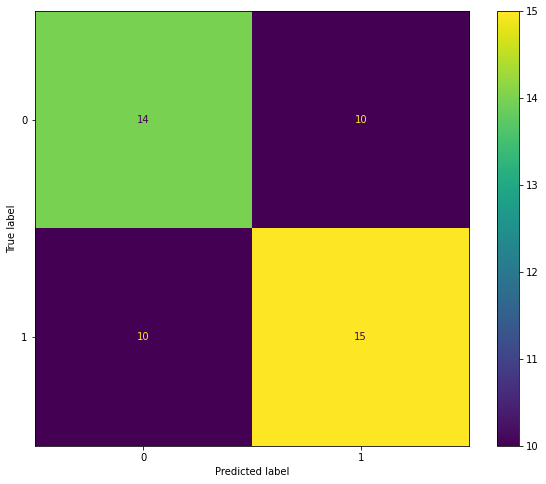

In [ ]:
# Creating confusion matrix for train set (default parameter)
print('Confusion Matrix Train Set LogReg (Default Parameter)')
cm = confusion_matrix(y_train, y_train_log, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logreg.classes_)

matplotlib.rcParams['figure.figsize'] = (10,8)
disp.plot()
plt.show()
     

In [ ]:
# Evaluating Train set (Hyperparameter Tuned)
print('Train Set (Hyperparameter Tuned)')
print('Accuracy - Train Set  : ', accuracy_score(y_train, y_train_log_final),)
print('F1 Score - Train Set  : ', f1_score(y_train, y_train_log_final), '\n')
print('Classification Report : \n', classification_report(y_train, y_train_log_final), '\n')

Train Set (Hyperparameter Tuned)
Accuracy - Train Set  :  1.0
F1 Score - Train Set  :  1.0 

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        25

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49
 



Confusion Matrix Train Set LogReg (Hyperparameter Tuned)


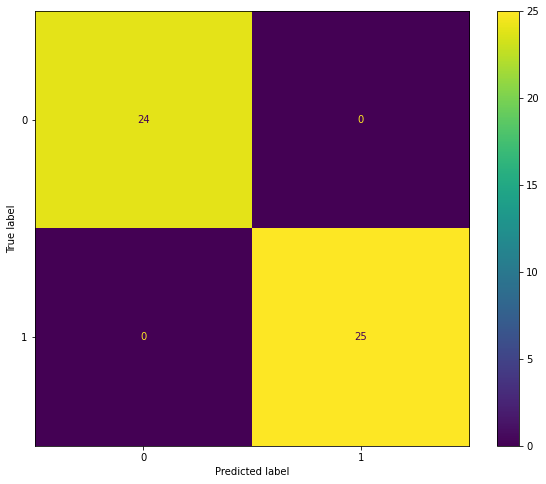

In [ ]:
# Creating confusion matrix for train set (labels parameter)
print('Confusion Matrix Train Set LogReg (Hyperparameter Tuned)')
cm = confusion_matrix(y_train, y_train_log_final, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logreg.classes_)

matplotlib.rcParams['figure.figsize'] = (10,8)
disp.plot()
plt.show()
     

### **SVC**

In [ ]:
# Evaluating Train set (Default Parameter)
print('Train Set (Defaul Parameter)')
print('Accuracy - Train Set  : ', accuracy_score(y_train, y_train_svm))
print('F1 Score - Train Set  : ', f1_score(y_train, y_train_svm), '\n')
print('Classification Report : \n', classification_report(y_train, y_train_svm), '\n')

Train Set (Defaul Parameter)
Accuracy - Train Set  :  0.5918367346938775
F1 Score - Train Set  :  0.6 

Classification Report : 
               precision    recall  f1-score   support

           0       0.58      0.58      0.58        24
           1       0.60      0.60      0.60        25

    accuracy                           0.59        49
   macro avg       0.59      0.59      0.59        49
weighted avg       0.59      0.59      0.59        49
 



Confusion Matrix Train Set SVM (Default Parameter)


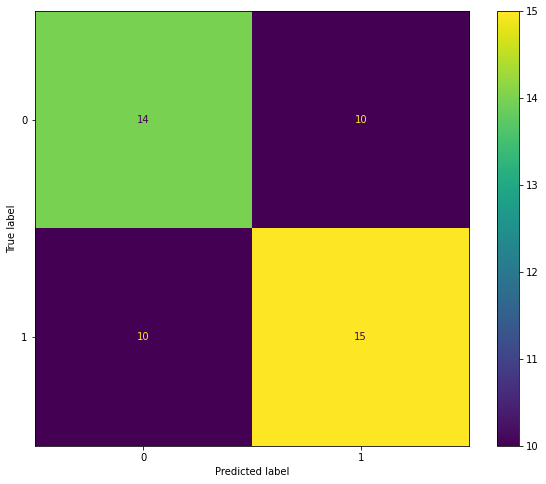

In [ ]:
# Creating confusion matrix for train set (default parameter)
print('Confusion Matrix Train Set SVM (Default Parameter)')
cm = confusion_matrix(y_train, y_train_svm, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=svm.classes_)

matplotlib.rcParams['figure.figsize'] = (10,8)
disp.plot()
plt.show()

In [ ]:
# Evaluating Train set (Hyperparameter Tuned)
print('Train Set (Hyperparameter Tuned)')
print('Accuracy - Train Set  : ', accuracy_score(y_train, y_train_svm_final),)
print('F1 Score - Train Set  : ', f1_score(y_train, y_train_svm_final), '\n')
print('Classification Report : \n', classification_report(y_train, y_train_svm_final), '\n')
     

Train Set (Hyperparameter Tuned)
Accuracy - Train Set  :  0.9795918367346939
F1 Score - Train Set  :  0.9803921568627451 

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        24
           1       0.96      1.00      0.98        25

    accuracy                           0.98        49
   macro avg       0.98      0.98      0.98        49
weighted avg       0.98      0.98      0.98        49
 



Confusion Matrix Train Set SVM (Hyperparameter Tuned)


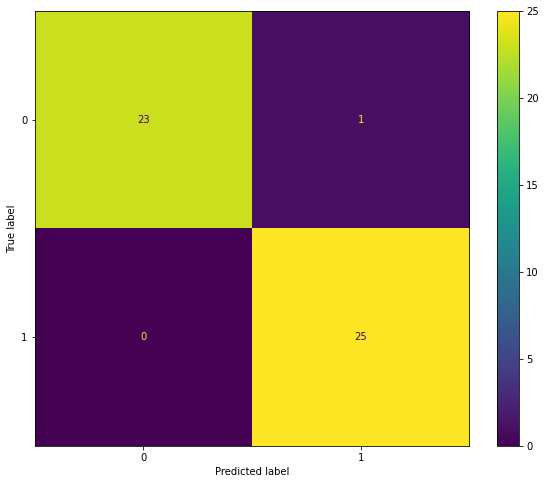

In [ ]:
# Creating confusion matrix for train set (hyperparameter tuned)
print('Confusion Matrix Train Set SVM (Hyperparameter Tuned)')
cm = confusion_matrix(y_train, y_train_svm_final, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=svm.classes_)

matplotlib.rcParams['figure.figsize'] = (10,8)
disp.plot()
plt.show()

### **Decision Tree**

In [ ]:
# Evaluating Train set (Default Parameter)
print('Train Set (Defaul Parameter)')
print('Accuracy - Train Set  : ', accuracy_score(y_train, y_train_dt))
print('F1 Score - Train Set  : ', f1_score(y_train, y_train_dt), '\n')
print('Classification Report : \n', classification_report(y_train, y_train_dt), '\n')

Train Set (Defaul Parameter)
Accuracy - Train Set  :  1.0
F1 Score - Train Set  :  1.0 

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        25

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49
 



Confusion Matrix Train Set Decision Tree (Default Parameter)


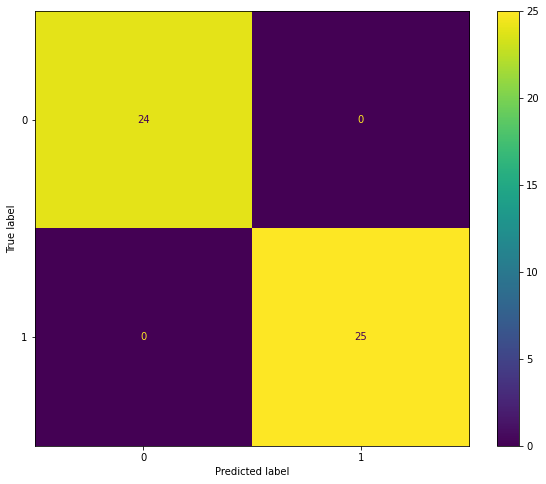

In [ ]:
# Creating confusion matrix for train set (default parameter)
print('Confusion Matrix Train Set Decision Tree (Default Parameter)')
cm = confusion_matrix(y_train, y_train_dt, labels=dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dt.classes_)

matplotlib.rcParams['figure.figsize'] = (10,8)
disp.plot()
plt.show()

In [ ]:
# Evaluating Train set (Hyperparameter Tuned)
print('Train Set (Hyperparameter Tuned)')
print('Accuracy - Train Set  : ', accuracy_score(y_train, y_train_dt_final),)
print('F1 Score - Train Set  : ', f1_score(y_train, y_train_dt_final), '\n')
print('Classification Report : \n', classification_report(y_train, y_train_dt_final), '\n')

Train Set (Hyperparameter Tuned)
Accuracy - Train Set  :  0.8979591836734694
F1 Score - Train Set  :  0.9019607843137256 

Classification Report : 
               precision    recall  f1-score   support

           0       0.91      0.88      0.89        24
           1       0.88      0.92      0.90        25

    accuracy                           0.90        49
   macro avg       0.90      0.90      0.90        49
weighted avg       0.90      0.90      0.90        49
 



In [ ]:
# Evaluating Test set (Hyperparameter Tuned)
print('Train Set (Hyperparameter Tuned)')
print('Accuracy - Train Set  : ', accuracy_score(y_test, y_test_dt_final),)
print('F1 Score - Train Set  : ', f1_score(y_test, y_test_dt_final), '\n')
print('Classification Report : \n', classification_report(y_test, y_test_dt_final), '\n')

Train Set (Hyperparameter Tuned)
Accuracy - Train Set  :  0.8095238095238095
F1 Score - Train Set  :  0.7777777777777777 

Classification Report : 
               precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.88      0.70      0.78        10

    accuracy                           0.81        21
   macro avg       0.82      0.80      0.81        21
weighted avg       0.82      0.81      0.81        21
 



Confusion Matrix Train Set Decision Tree (Hyperparameter Tuned)


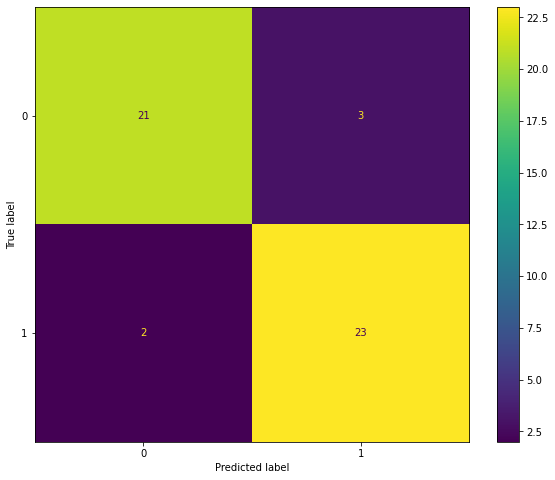

In [ ]:
# Creating confusion matrix for train set (hyperparameter tuned)
print('Confusion Matrix Train Set Decision Tree (Hyperparameter Tuned)')
cm = confusion_matrix(y_train, y_train_dt_final, labels=dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dt.classes_)

matplotlib.rcParams['figure.figsize'] = (10,8)
disp.plot()
plt.show()

Confusion Matrix Train Set Decision Tree (Hyperparameter Tuned)


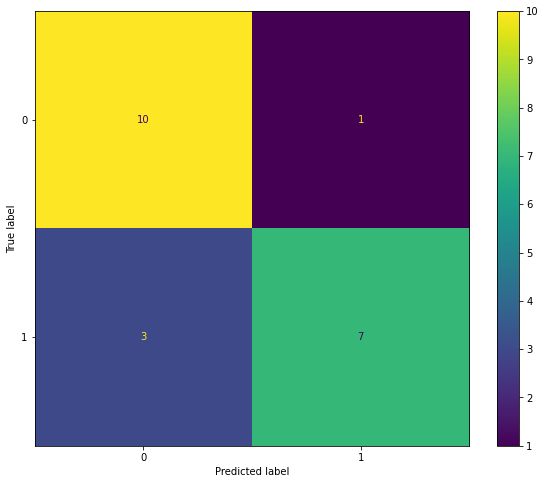

In [ ]:
# Creating confusion matrix for test set (hyperparameter tuned)
print('Confusion Matrix Train Set Decision Tree (Hyperparameter Tuned)')
cm = confusion_matrix(y_test, y_test_dt_final, labels=dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dt.classes_)

matplotlib.rcParams['figure.figsize'] = (10,8)
disp.plot()
plt.show()

### **Random Forest**

In [ ]:
# Evaluating Train set (Default Parameter)
print('Train Set (Defaul Parameter)')
print('Accuracy - Train Set  : ', accuracy_score(y_train, y_train_rfc))
print('F1 Score - Train Set  : ', f1_score(y_train, y_train_rfc), '\n')
print('Classification Report : \n', classification_report(y_train, y_train_rfc), '\n')

Train Set (Defaul Parameter)
Accuracy - Train Set  :  1.0
F1 Score - Train Set  :  1.0 

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        25

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49
 



Confusion Matrix Train Set Random Forest Classifier (Default Parameter)


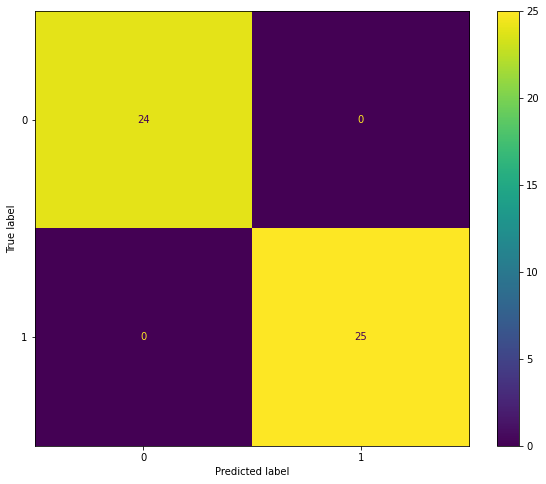

In [ ]:
# Creating confusion matrix for train set (default parameter)
print('Confusion Matrix Train Set Random Forest Classifier (Default Parameter)')
cm = confusion_matrix(y_train, y_train_rfc, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfc.classes_)

matplotlib.rcParams['figure.figsize'] = (10,8)
disp.plot()
plt.show()

In [ ]:
# Evaluating Train set (Hyperparameter Tuned)
print('Train Set (Hyperparameter Tuned)')
print('Accuracy - Train Set  : ', accuracy_score(y_train, y_train_rfc_final),)
print('F1 Score - Train Set  : ', f1_score(y_train, y_train_rfc_final), '\n')
print('Classification Report : \n', classification_report(y_train, y_train_rfc_final), '\n')

Train Set (Hyperparameter Tuned)
Accuracy - Train Set  :  0.9795918367346939
F1 Score - Train Set  :  0.9803921568627451 

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        24
           1       0.96      1.00      0.98        25

    accuracy                           0.98        49
   macro avg       0.98      0.98      0.98        49
weighted avg       0.98      0.98      0.98        49
 



Confusion Matrix Train Set Random Forest Classifier (Hyperparameter Tuned)


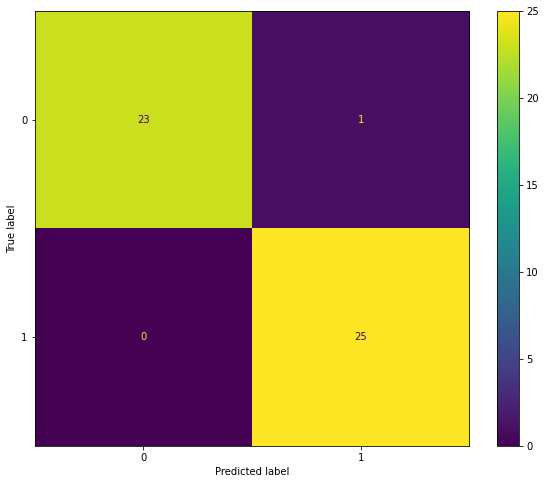

In [ ]:
# Creating confusion matrix for train set (hyperparameter tuned)
print('Confusion Matrix Train Set Random Forest Classifier (Hyperparameter Tuned)')
cm = confusion_matrix(y_train, y_train_rfc_final, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfc.classes_)

matplotlib.rcParams['figure.figsize'] = (10,8)
disp.plot()
plt.show()

Confusion Matrix Train Set Random Forest Classifier (Hyperparameter Tuned)


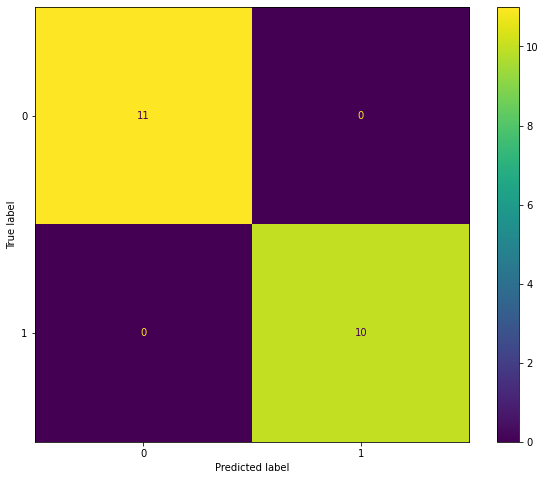

In [ ]:
# Creating confusion matrix for train set (hyperparameter tuned)
print('Confusion Matrix Train Set Random Forest Classifier (Hyperparameter Tuned)')
cm = confusion_matrix(y_test, y_test_rfc_final, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfc.classes_)

matplotlib.rcParams['figure.figsize'] = (10,8)
disp.plot()
plt.show()

## **Model Saving**

In [ ]:
# Save the model files
with open('rfc_gridcv.pkl', 'wb') as file_1:
  joblib.dump(rfc_gridcv_best, file_1)

In [ ]:
# Load all model files
with open('rfc_gridcv.pkl', 'rb') as file_1:
  rfc_model = joblib.load(file_1)

## **Model Inference**

In [ ]:
df_inf

,Date,Present,Next,Class
5,2022-09-23,1354.72,1353.38,0
6,2022-09-26,1353.38,1352.19,0
29,2022-10-27,1348.47,1349.35,1
48,2022-11-23,1366.34,1369.12,1
61,2022-12-12,1364.91,1364.81,0


In [ ]:
# Predict target inference
y_inf = rfc_model.predict(df_inf)
y_inf = pd.DataFrame(y_inf, columns=['Prediction'],index=df_inf.index)

In [ ]:
# Comparing the real target and prediction
model_inf = pd.concat([df_inf['Class'], y_inf['Prediction']], axis=1).sort_index()
model_inf

,Class,Prediction
5,0,0
6,0,0
29,1,1
48,1,1
61,0,0
